In [1]:
!pip install -q deap

In [2]:
import random
import os
import matplotlib.pyplot as plt
import cv2
from deap import base, creator, tools, algorithms
from shapely.geometry import Polygon
from shapely.affinity import translate, rotate
from shapely import affinity

In [3]:
# ============================================================
# FUNCIÓN DE CARGA DE MOLDES
# ============================================================
def cargar_moldes_desde_png(path_png, threshold=180, simplify_tol=1.0, scale_factor=1.0):
    img = cv2.imread(path_png, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen: {path_png}")

    _, mask = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    piezas = []
    for cnt in contours:
        if len(cnt) < 3:
            continue
        if cv2.contourArea(cnt) < 20:
            continue

        coords = [tuple(pt[0]) for pt in cnt]
        poly = Polygon(coords)
        if not poly.is_valid:
            poly = poly.buffer(0)
        poly = poly.simplify(simplify_tol, preserve_topology=True)
        poly = affinity.scale(poly, xfact=scale_factor, yfact=scale_factor, origin=(0, 0))

        if poly.area > 10:
            piezas.append(poly)

    print(f"✅ {os.path.basename(path_png)} → {len(piezas)} moldes válidos.")
    return piezas

In [4]:
# ------------------------------
# Parámetros del problema
# ------------------------------
STRIP_HEIGHT = 150  # alto fijo del rollo
ANGLES = [0, 90, 180, 270]
SCALE_FACTOR = 160 / 432
MARGIN_BETWEEN = 1  # cm entre prendas
RUTA_DATASET = "moldes"
PLACED_ALL = []
NAMES_ALL = []
PRENDA_WIDTHS = []
X_OFFSET = 0
TOTAL_WIDTH = 0

In [5]:
# ------------------------------
# Placement horizontal
# ------------------------------
def place_piece(y, idx, phi, placed, PIECES, strip_height=STRIP_HEIGHT):
    poly = PIECES[idx]
    poly_rot = rotate(poly, phi, origin=(0,0), use_radians=False)

    minx, miny, maxx, maxy = poly_rot.bounds
    w = maxx - minx
    h = maxy - miny

    # clamp en y
    y = min(max(0, y), strip_height - h)

    # calcular x_base: máximo borde derecho de piezas que solapan en Y
    x_base = 0
    for other in placed:
        ox1, oy1, ox2, oy2 = other.bounds
        if not (y + h <= oy1 or y >= oy2):  # hay solape en Y
            x_base = max(x_base, ox2)

    # trasladar polígono a (x_base, y)
    poly_pos = translate(poly_rot, xoff=x_base - minx, yoff=y - miny)

    # slide down
    while True:
        new_poly = translate(poly_pos, yoff=-1)
        if new_poly.bounds[1] < 0 or any(new_poly.overlaps(r) for r in placed):
            break
        poly_pos = new_poly

    return poly_pos


def place_pieces(individual, PIECES):
    placed = []
    max_x = 0
    for (y, idx, phi) in individual:
        poly = place_piece(y, idx, phi, placed, PIECES, strip_height=STRIP_HEIGHT)
        placed.append(poly)
        max_x = max(max_x, poly.bounds[2])  # borde derecho más alejado
    return max_x, placed

In [6]:
# ============================================================
# FUNCIÓN: ejecutar GA una vez para una prenda
# ============================================================
def run_ga_for_prenda(prenda, PIECES, toolbox, ngen=50, npop=50, verbose=False):
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum(f[0] for f in x) / len(x))
    stats.register("min", lambda x: min(f[0] for f in x))

    pop = toolbox.population(n=npop)
    pop, log = algorithms.eaSimple(
        pop, toolbox,
        cxpb=0.7, mutpb=0.3,
        ngen=ngen,
        stats=stats,
        halloffame=hof,
        verbose=verbose
    )

    best_ind = hof[0]
    used_width, placed = place_pieces(best_ind, PIECES)
    best_fitness = best_ind.fitness.values[0]

    return best_ind, best_fitness, used_width, placed, log

In [7]:
# ============================
# Gráfico de convergencia
# ============================
def plot_convergence(prenda, log):
    gen = log.select("gen")
    avg = log.select("avg")
    min_ = log.select("min")

    plt.figure(figsize=(8, 4))
    plt.plot(gen, avg, label="Fitness promedio", color="orange")
    plt.plot(gen, min_, label="Mejor fitness (mínimo)", color="blue")
    plt.xlabel("Generación")
    plt.ylabel("Fitness")
    plt.title(f"Convergencia del algoritmo - {prenda.upper()}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# ============================
# Diagrama de cajas
# ============================
def plot_boxplot(prenda, pop):
    fitness_vals = [ind.fitness.values[0] for ind in pop]

    plt.figure(figsize=(5, 4))
    plt.boxplot(fitness_vals, patch_artist=True,
                boxprops=dict(facecolor="lightblue", color="navy"),
                medianprops=dict(color="red"),
                whiskerprops=dict(color="gray"))
    plt.title(f"Distribución del fitness - {prenda.upper()}")
    plt.ylabel("Fitness")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

In [8]:
# ------------------------------
# Fitness
# ------------------------------
def evaluate(individual, PIECES):
    used_width, placed = place_pieces(individual, PIECES)
    total_area = sum(p.area for p in PIECES)
    strip_area = used_width * STRIP_HEIGHT if used_width > 0 else 1.0
    efficiency_loss = 1.0 - (total_area / strip_area)
    return (used_width + 0.001 * efficiency_loss,)  # minimizar ancho usado

In [9]:
# ------------------------------
# Visualización
# ------------------------------
def plot_layout(polygons, names, strip_height, used_width, title="Layout Horizontal"):
    fig, ax = plt.subplots(figsize=(14, 5))
    color_map = {
        "S": "#17becf",
        "P": "#1f77b4",
        "M": "#ff7f0e",
        "G": "#2ca02c",
        "XG": "#9467bd",
        "GG": "#d62728"
    }

    def color_por_talle(nombre):
        for k in sorted(color_map.keys(), key=len, reverse=True):
            if f"-{k}" in nombre:
                return color_map[k]
        return "#999999"

    # 🔹 Dibujar las piezas (mantener esto igual)
    for idx, (poly, name) in enumerate(zip(polygons, names)):
        if not poly.is_empty:
            color = color_por_talle(name)
            x, y = poly.exterior.xy
            ax.fill(x, y, alpha=0.6, fc=color, edgecolor="k")
            cx, cy = poly.centroid.x, poly.centroid.y
            ax.text(cx, cy, name.split('-')[1].split('.')[0], ha="center", va="center", fontsize=7, color="white")

    # 🔹 Agregar líneas divisorias (acá es el lugar correcto)
    acc = 0
    for w in PRENDA_WIDTHS[:-1]:  # lista global de anchos por prenda
        acc += w + MARGIN_BETWEEN
        ax.axvline(x=acc, color="gray", linestyle="--", linewidth=1)

    # 🔹 Dibujar borde del rollo
    ax.plot([0, used_width, used_width, 0, 0],
            [0, 0, strip_height, strip_height, 0], "k--")

    ax.set_xlim(0, used_width + 5)
    ax.set_ylim(0, strip_height + 5)
    ax.set_aspect("equal")
    ax.set_title(title)
    plt.show()

✅ calzoncillo-G.png → 5 moldes válidos.
✅ calzoncillo-M.png → 5 moldes válidos.
✅ calzoncillo-P.png → 5 moldes válidos.

🔹 Optimizando CALZONCILLO (15 moldes en total)



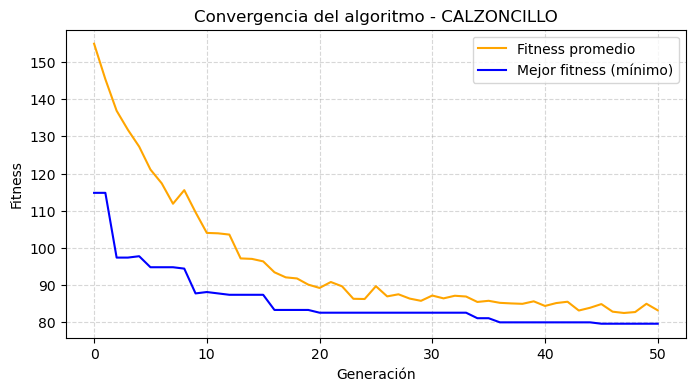

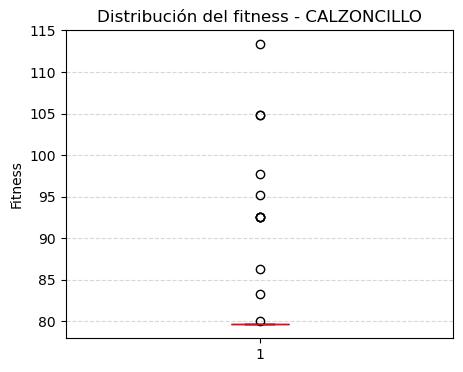

✅ camisa-M.png → 20 moldes válidos.

🔹 Optimizando CAMISA (20 moldes en total)



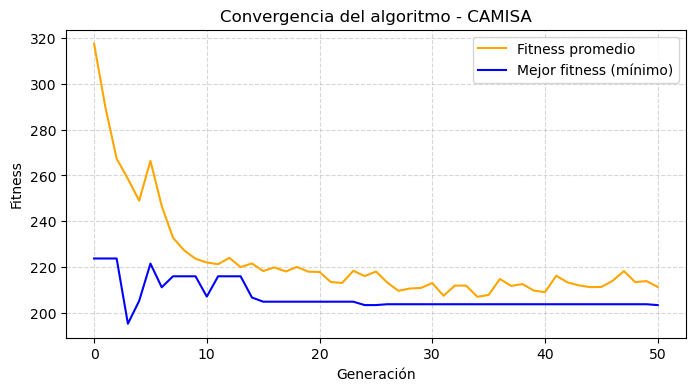

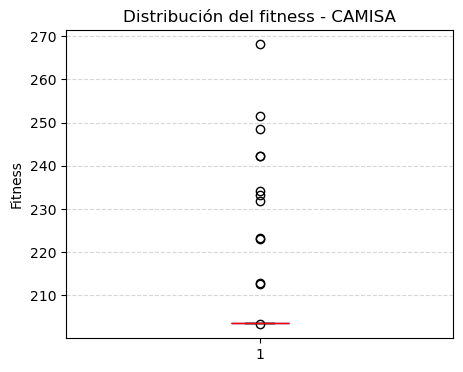

✅ remera-G.png → 4 moldes válidos.
✅ remera-M.png → 4 moldes válidos.
✅ remera-P.png → 4 moldes válidos.

🔹 Optimizando REMERA (12 moldes en total)



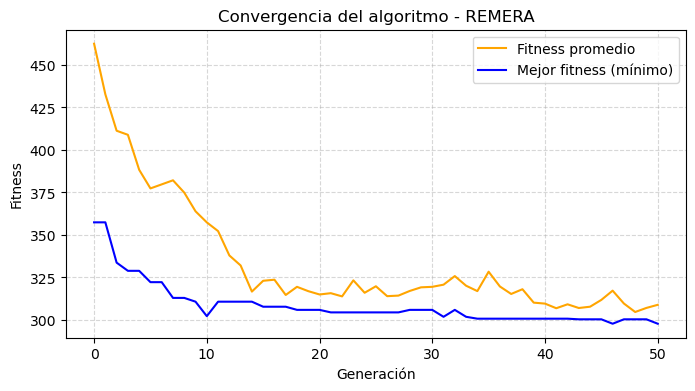

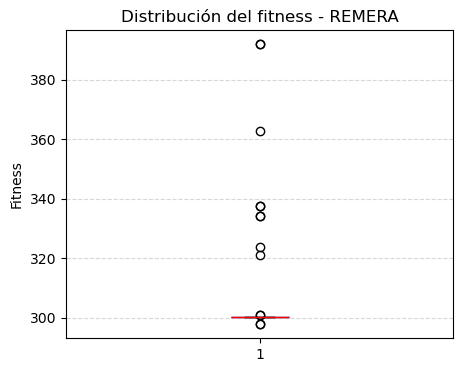


🏁 Layout final generado (ancho total = 578.59 cm)


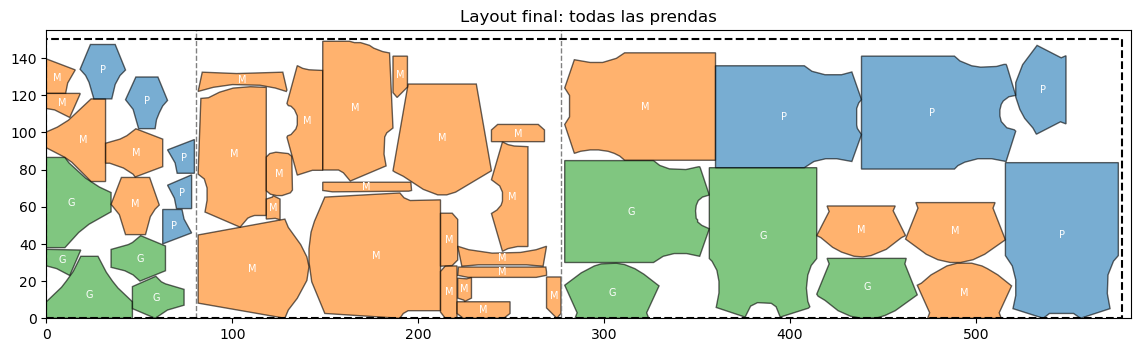

In [10]:
# ------------------------------
# Creación global de creator (una sola vez)
# ------------------------------
if "FitnessMin" not in creator.__dict__:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMin)

# ============================================================
# LOOP GLOBAL — TODAS LAS PRENDAS EN UNA TELA
# ============================================================

for prenda in ["calzoncillo", "camisa", "remera"]:
    carpeta = os.path.join(RUTA_DATASET, prenda)
    archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if f.lower().endswith(".png")]

    PIECES, NAMES = [], []
    for path in archivos:
        piezas = cargar_moldes_desde_png(path, scale_factor=SCALE_FACTOR)  # asumimos que ya tenés esta función definida
        PIECES.extend(piezas)
        NAMES.extend([os.path.basename(path)] * len(piezas))

    N = len(PIECES)
    print(f"\n🔹 Optimizando {prenda.upper()} ({N} moldes en total)\n")

    toolbox = base.Toolbox()

    def init_individual():
        indices = random.sample(range(N), N)
        ind = []
        for i in indices:
            minx, miny, maxx, maxy = PIECES[i].bounds
            h = maxy - miny
            y = random.randint(0, int(STRIP_HEIGHT - h))
            phi = random.choice(ANGLES)
            ind.append((y, i, phi))
        return creator.Individual(ind)

    toolbox.register("individual", init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    def cx_pmx_tuples(ind1, ind2):
        idx1 = [gene[1] for gene in ind1]
        idx2 = [gene[1] for gene in ind2]
        tools.cxPartialyMatched(idx1, idx2)
        child1, child2 = [], []
        for new_idx, tpl1, tpl2 in zip(idx1, ind1, ind2):
            if random.random() < 0.5:
                y, _, phi = tpl1
            else:
                y, _, phi = tpl2
            child1.append((y, new_idx, phi))
        for new_idx, tpl1, tpl2 in zip(idx2, ind1, ind2):
            if random.random() < 0.5:
                y, _, phi = tpl1
            else:
                y, _, phi = tpl2
            child2.append((y, new_idx, phi))
        ind1[:], ind2[:] = child1, child2
        return ind1, ind2

    def mut_tuples(ind):
        if random.random() < 0.3:
            i, j = random.sample(range(len(ind)), 2)
            ind[i], ind[j] = ind[j], ind[i]
        else:
            k = random.randrange(len(ind))
            y, i, phi = ind[k]
            if random.random() < 0.5:
                minx, miny, maxx, maxy = PIECES[i].bounds
                h = maxy - miny
                y = random.randint(0, STRIP_HEIGHT - int(h))
            else:
                phi = random.choice(ANGLES)
            ind[k] = (y, i, phi)
        return (ind,)

    toolbox.register("mate", cx_pmx_tuples)
    toolbox.register("mutate", mut_tuples)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate, PIECES=PIECES)

    # Ejecutar GA
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: sum(f[0] for f in x) / len(x))
    stats.register("min", lambda x: min(f[0] for f in x))

    pop, log = algorithms.eaSimple(pop, toolbox,
                                   cxpb=0.7, mutpb=0.3,
                                   ngen=50,
                                   stats=stats, halloffame=hof,
                                   verbose=False)

    best = hof[0]
    used_width, placed = place_pieces(best, PIECES)

    # Gráfico de convergencia
    plot_convergence(prenda, log)

    # Diagrama de cajas (última generación)
    plot_boxplot(prenda, pop)

    # Mover toda la prenda a la derecha del área ya ocupada
    placed_shifted = [affinity.translate(p, xoff=X_OFFSET, yoff=0) for p in placed]
    PLACED_ALL.extend(placed_shifted)
    NAMES_ALL.extend(NAMES)

    PRENDA_WIDTHS.append(used_width)

    X_OFFSET += used_width + MARGIN_BETWEEN + 1
    TOTAL_WIDTH = X_OFFSET

print(f"\n🏁 Layout final generado (ancho total = {TOTAL_WIDTH:.2f} cm)")
plot_layout(PLACED_ALL, NAMES_ALL, STRIP_HEIGHT, TOTAL_WIDTH, title="Layout final: todas las prendas")